# Library

In [1]:
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#os.environ['TF_DETERMINISTIC_OPS'] = '1'
plt.rcParams["font.family"] = "Malgun Gothic"  

# Prep

In [2]:
df_fx = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\data\df_investing2.csv")

df_sentiment = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\crawler\data\naver_finance_news_sentiment_score.csv")

df_fx["date"] = pd.to_datetime(df_fx["date"]).dt.date
df_sentiment["date"] = pd.to_datetime(df_sentiment["date"]).dt.date

# 병합 
df= pd.merge(df_fx, df_sentiment[["date", "sentiment score"]], on="date", how="left")

In [3]:
# 결측치 0으로 채움
df["sentiment score"] = df["sentiment score"].fillna(0)

In [4]:
# scaler 객체 생성
scaler = StandardScaler()

# 'Z-score 정규화 
df['sentiment score'] = scaler.fit_transform(df[['sentiment score']])

In [5]:
df

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,6.445500e+08,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-1.283978
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,8.141300e+08,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-1.283978
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,8.292900e+08,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-1.283978
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,6.451000e+08,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-0.843971
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,6.577100e+08,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,0.036043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,2020-01-08,1162.25,1168.30,2151.31,913830000.0,640.94,1.380000e+09,59.97,1555.81,28745.09,296430000.0,3253.10,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,-1.283978
1182,2020-01-07,1167.30,1167.54,2175.54,568240000.0,663.44,9.703100e+08,64.92,1573.99,28583.68,266680000.0,3237.20,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,1.356063
1183,2020-01-06,1166.94,1165.89,2155.07,592670000.0,655.31,8.842800e+08,62.99,1565.96,28703.38,261810000.0,3246.30,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,-1.283978
1184,2020-01-03,1164.95,1157.95,2176.46,631560000.0,669.93,9.038600e+08,63.10,1551.65,28634.88,239590000.0,3234.80,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,-1.283978


In [6]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())
    
    print("\nInfo:")
    print(df.info())
    
    print("\nDescribe (numeric):")
    display(df.describe())
    
    print("\nNull counts:")
    print(df.isnull().sum())
    
    print("="*40)

In [7]:
eda_basic_info(df, "df")


===== df =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-0.843971
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.036043



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1186 non-null   object 
 1   USD_KRW 종가       1186 non-null   float64
 2   USD_KRW 시가       1186 non-null   float64
 3   KOSPI 종가         1186 non-null   float64
 4   KOSPI 거래량        1186 non-null   float64
 5   KOSDAQ 종가        1186 non-null   float64
 6   KOSDAQ 거래량       1186 non-null   float64
 7   WTI Price        1186 non-null   float64
 8   XAU Price        1186 non-null   float64
 9   DJI 종가           1186 non-null   float64
 10  DJI 거래량          1186 non-null   float64
 11  SP500 종가         1186 non-null   float64
 12  M1               1186 non-null   float64
 13  M2               1186 non-null   float64
 14  한국 정책금리          1186 non-null   float64
 15  미국 정책금리          1186 non-null   float64
 16  CPI              1186 non-null   float64
 17  PPI    

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1.186000e+03
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,1.347994e-17
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,1.000422e+00
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,-1.283978e+00
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,-1.283978e+00
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,3.604271e-02
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,1.356063e+00
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,1.356063e+00



Null counts:
date               0
USD_KRW 종가         0
USD_KRW 시가         0
KOSPI 종가           0
KOSPI 거래량          0
KOSDAQ 종가          0
KOSDAQ 거래량         0
WTI Price          0
XAU Price          0
DJI 종가             0
DJI 거래량            0
SP500 종가           0
M1                 0
M2                 0
한국 정책금리            0
미국 정책금리            0
CPI                0
PPI                0
경상수지               0
sentiment score    0
dtype: int64


# Prep 2(변수 선택)

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


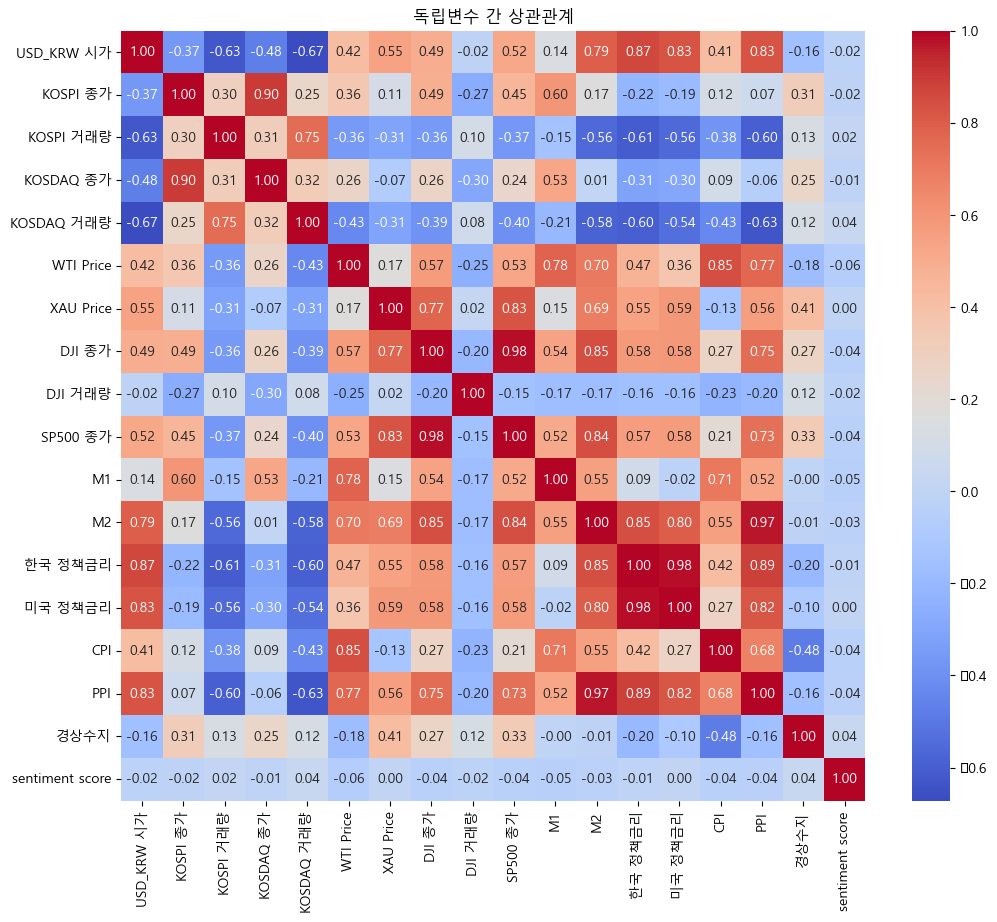

In [15]:
target = 'USD_KRW 종가'
df_numeric = df.drop(columns=['date'])  

X = df_numeric.drop(columns=[target])
y = df_numeric[target]

# 변수 간 상관관계 시각화

corr_matrix = X.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('독립변수 간 상관관계')
plt.show()

In [16]:
# 다중공선성이 높은 변수 제거

# 임계치(threshold) 0.9 이상인 변수 쌍 중 한 변수를 제거
def remove_highly_correlated_features(corr_matrix, threshold=0.9):
    to_drop = set()
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                to_drop.add(cols[j])
    return list(to_drop)

features_to_drop = remove_highly_correlated_features(corr_matrix, threshold=0.9)
print("다중공선성이 높아 제거할 변수:", features_to_drop)

다중공선성이 높아 제거할 변수: ['미국 정책금리', 'PPI', 'SP500 종가']


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


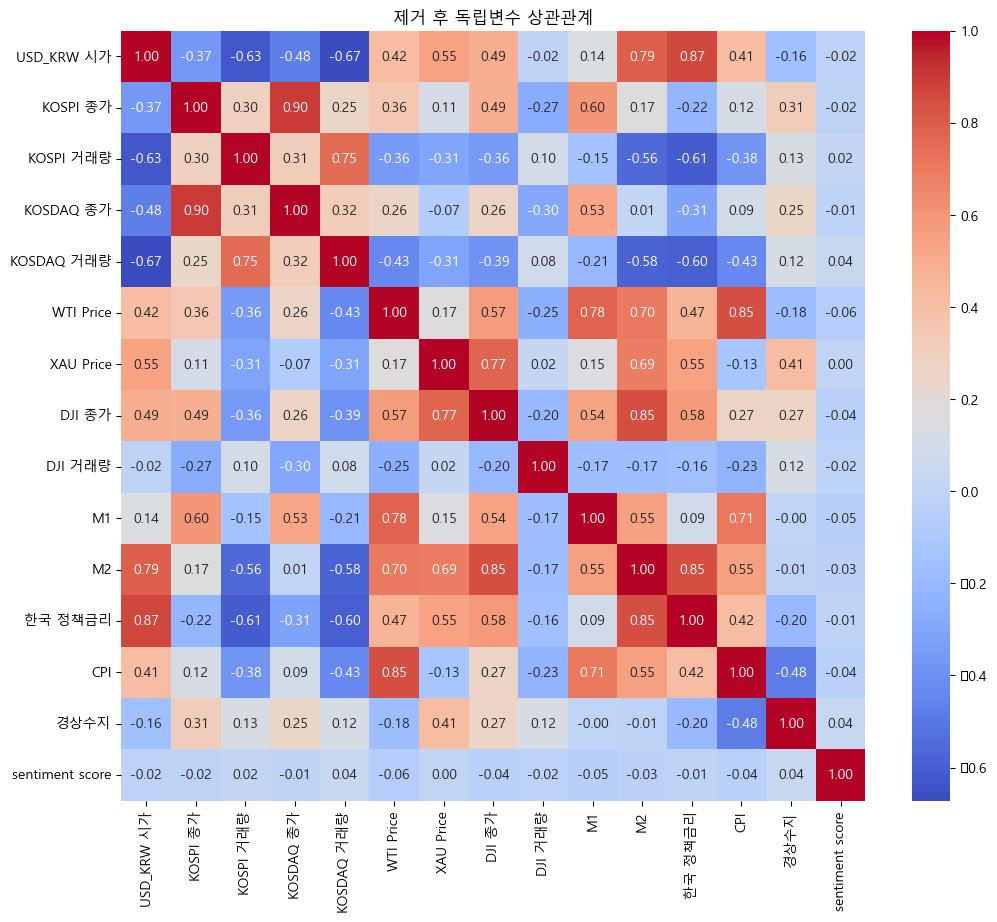

In [17]:
# 제거된 변수들 제외한 데이터셋 생성
X_reduced = X.drop(columns=features_to_drop)

# 제거 후 상관관계 확인
corr_matrix_reduced = X_reduced.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_reduced, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('제거 후 독립변수 상관관계')
plt.show()

            Feature  Importance
0        USD_KRW 시가    0.995056
2         KOSPI 거래량    0.000598
8           DJI 거래량    0.000582
4        KOSDAQ 거래량    0.000565
1          KOSPI 종가    0.000565
7            DJI 종가    0.000468
5         WTI Price    0.000461
3         KOSDAQ 종가    0.000447
6         XAU Price    0.000434
13             경상수지    0.000242
14  sentiment score    0.000210
9                M1    0.000128
10               M2    0.000087
12              CPI    0.000085
11          한국 정책금리    0.000069


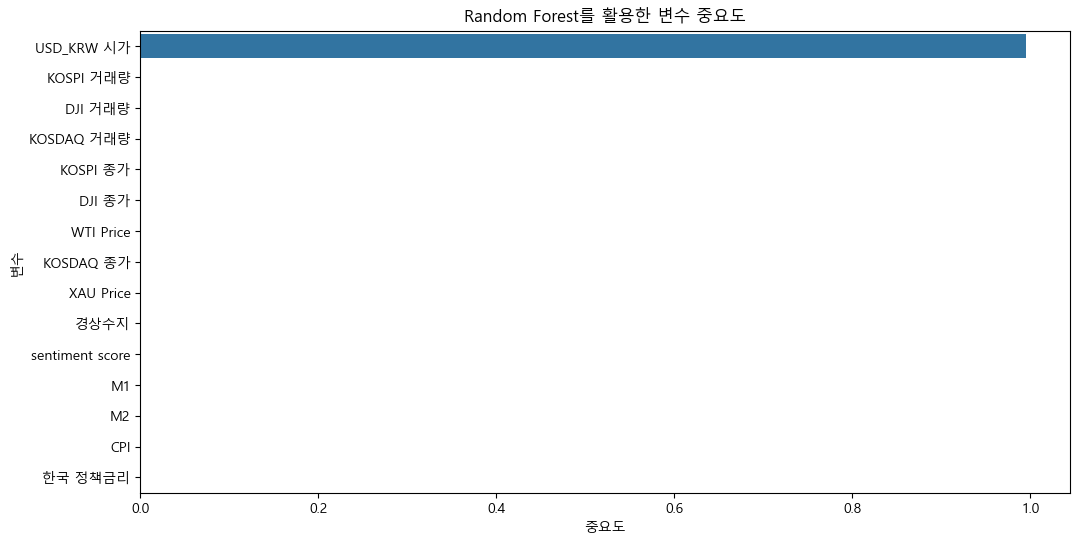

In [20]:
# 4Random Forest Regressor를 활용한 변수별 중요도 산출
# 학습/테스트 데이터 분할 (예: 80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# RandomForestRegressor 모델 생성 및 학습
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 변수 중요도 산출
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest를 활용한 변수 중요도')
plt.xlabel('중요도')
plt.ylabel('변수')
plt.show()

In [8]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
target_column = 'USD_KRW 종가'
# 변수 거거
columns_to_drop = ['date', target_column, '미국 정책금리', 'PPI', 'SP500 종가', 'M2', 'CPI', '한국 정책금리']

# 독립변수 
features = df.drop(columns=columns_to_drop)
# 종속변수
target = df[target_column].values

# numpy array로 변환
features = features.values

# 스케일러 선언
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# 스케일링 수행
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

In [9]:
# target_column = 'USD_KRW 종가'
# features = df.drop(columns=['date', target_column])  # 독립변수
# target = df[target_column].values                    # 종속변수 (USD_KRW 종가)

# features = features.values  # numpy array 변환

# # 스케일러 선언
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # 스케일링
# features_scaled = scaler_x.fit_transform(features)
# target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

In [9]:
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

window_size = 5
X, y = create_sequences(features_scaled, target_scaled, window_size)

# 시간 순서대로 학습/테스트 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modeling

In [10]:
# -----------------------------
# LSTM 모델
# -----------------------------
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train, y_train, 
                              epochs=50, batch_size=16, verbose=1, 
                              callbacks=[early_stop])

# -----------------------------
# GRU 모델
# -----------------------------
gru_model = Sequential([
    GRU(50, activation='tanh', input_shape=(window_size, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

gru_history = gru_model.fit(X_train, y_train, 
                            epochs=50, batch_size=16, verbose=1, 
                            callbacks=[early_stop])

# -----------------------------
# CNN-LSTM 모델
# -----------------------------
cnn_lstm_model = Sequential([
    Conv1D(filters=256, kernel_size=3, activation='relu', 
           input_shape=(window_size, X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.summary()

cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train,
                                      epochs=50, batch_size=16, verbose=1,
                                      callbacks=[early_stop])

# -----------------------------
# CNN-GRU 모델
# -----------------------------
cnn_gru_model = Sequential([
    Conv1D(filters=256, kernel_size=3, activation='relu',
           input_shape=(window_size, X.shape[2])),
    MaxPooling1D(pool_size=2),
    GRU(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
cnn_gru_model.compile(optimizer='adam', loss='mse')
cnn_gru_model.summary()

cnn_gru_history = cnn_gru_model.fit(X_train, y_train,
                                    epochs=50, batch_size=16, verbose=1,
                                    callbacks=[early_stop])

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0736  
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 13/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 14/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 15/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 16/50
59/59

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,651 (37.70 KB)

 Trainable params: 9,651 (37.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1427  
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0217
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 13/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 14/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 15/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 16/50
59/59

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 32)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,451 (68.17 KB)

 Trainable params: 17,451 (68.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0990  
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 14/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 15/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 16/50
59/59

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 4, 32)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,451 (52.54 KB)

 Trainable params: 13,451 (52.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1009  
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 13/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 14/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 15/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 16/50
59/59

In [11]:
# 테스트셋 예측
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)
cnn_lstm_pred = cnn_lstm_model.predict(X_test)
cnn_gru_pred = cnn_gru_model.predict(X_test)

# 스케일 복원
y_test_inv = scaler_y.inverse_transform(y_test)
lstm_pred_inv = scaler_y.inverse_transform(lstm_pred)
gru_pred_inv = scaler_y.inverse_transform(gru_pred)
cnn_lstm_pred_inv = scaler_y.inverse_transform(cnn_lstm_pred)
cnn_gru_pred_inv = scaler_y.inverse_transform(cnn_gru_pred)

# MSE, MAPE 계산
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)
gru_mse = mean_squared_error(y_test_inv, gru_pred_inv)
cnn_lstm_mse = mean_squared_error(y_test_inv, cnn_lstm_pred_inv)
cnn_gru_mse = mean_squared_error(y_test_inv, cnn_gru_pred_inv)

lstm_mape = mean_absolute_percentage_error(y_test_inv, lstm_pred_inv) * 100
gru_mape = mean_absolute_percentage_error(y_test_inv, gru_pred_inv) * 100
cnn_lstm_mape = mean_absolute_percentage_error(y_test_inv, cnn_lstm_pred_inv) * 100
cnn_gru_mape = mean_absolute_percentage_error(y_test_inv, cnn_gru_pred_inv) * 100

print("===== 평가 지표(MSE, MAPE) =====")
print("LSTM     : MSE={:.4f}, MAPE={:.3f}%".format(lstm_mse, lstm_mape))
print("GRU      : MSE={:.4f}, MAPE={:.3f}%".format(gru_mse, gru_mape))
print("CNN-LSTM : MSE={:.4f}, MAPE={:.3f}%".format(cnn_lstm_mse, cnn_lstm_mape))
print("CNN-GRU  : MSE={:.4f}, MAPE={:.3f}%".format(cnn_gru_mse, cnn_gru_mape))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
===== 평가 지표(MSE, MAPE) =====
LSTM     : MSE=199.7277, MAPE=0.868%
GRU      : MSE=63.6984, MAPE=0.504%
CNN-LSTM : MSE=495.3255, MAPE=1.613%
CNN-GRU  : MSE=183.2050, MAPE=0.858%


In [ ]:
===== 평가 지표(MSE, MAPE) =====
LSTM     : MSE=199.7277, MAPE=0.868%
GRU      : MSE=63.6984, MAPE=0.504%
CNN-LSTM : MSE=495.3255, MAPE=1.613%
CNN-GRU  : MSE=183.2050, MAPE=0.858%

In [ ]:
===== 평가 지표(MSE, MAPE) =====
LSTM     : MSE=86.5513, MAPE=0.627%
GRU      : MSE=124.0849, MAPE=0.790%
CNN-LSTM : MSE=244.4938, MAPE=1.067%
CNN-GRU  : MSE=232.4623, MAPE=0.974%

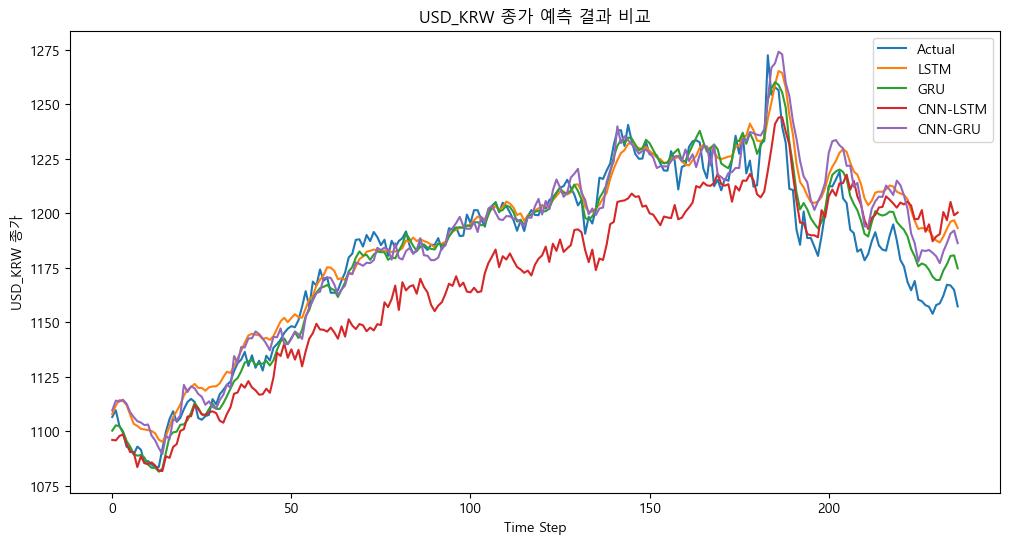

In [12]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_pred_inv, label='LSTM')
plt.plot(gru_pred_inv, label='GRU')
plt.plot(cnn_lstm_pred_inv, label='CNN-LSTM')
plt.plot(cnn_gru_pred_inv, label='CNN-GRU')
plt.title('USD_KRW 종가 예측 결과 비교')
plt.xlabel('Time Step')
plt.ylabel('USD_KRW 종가')
plt.legend()
plt.show()

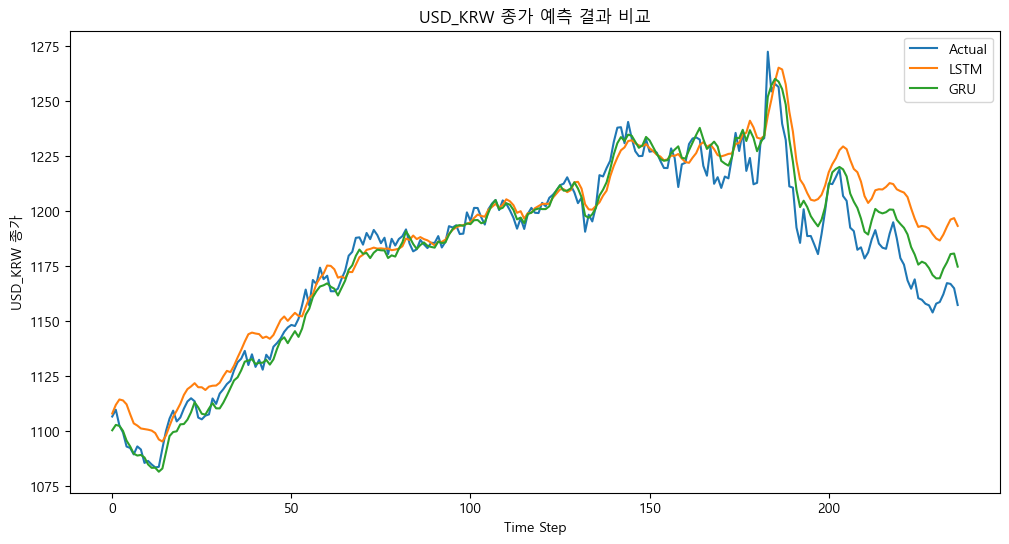

In [13]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_pred_inv, label='LSTM')
plt.plot(gru_pred_inv, label='GRU')
#plt.plot(cnn_lstm_pred_inv, label='CNN-LSTM')
#plt.plot(cnn_gru_pred_inv, label='CNN-GRU')
plt.title('USD_KRW 종가 예측 결과 비교')
plt.xlabel('Time Step')
plt.ylabel('USD_KRW 종가')
plt.legend()
plt.show()

In [7]:
## 0. Seed 설정
#seed = 123
#p.random.seed(seed)
#tf.random.set_seed(seed)
#random.seed(seed)

In [8]:
## 1. Prep
# datetime으로 변환 후 정렬
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Train: 2020 ~ 2023, Test : 2023 ~ 2024
train_df = df[df['date'] < '2023-01-01'].copy()
test_df = df[df['date'] >= '2023-01-01'].copy()

# date 컬럼 제거
train_data = train_df.drop(columns=['date']).values
test_data = test_df.drop(columns=['date']).values

# MinMax 스케일링 
scaler = MinMaxScaler()
scaler.fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [9]:
## 2. DataSet
def create_sequences(data, window_size, target_index=0):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_index])
    return np.array(X), np.array(y)

window_size = 10  # 과거 시점의 길이 (시퀀스 길이) (몇으로 설정?)
X_train, y_train = create_sequences(train_scaled, window_size, target_index=0) # target_index=0 은 USD_KRW 종가
X_test, y_test = create_sequences(test_scaled, window_size, target_index=0)

# CNN-LSTM, CNN-GRU 모델은 4차원 입력 필요 (samples, n_seq, n_steps, n_features)
n_seq = 2
n_steps = window_size // n_seq  
n_features = X_train.shape[2]

X_train_cnn = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_test_cnn = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

In [10]:
## 3. Build Model
# LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mape'])
    return model

# GRU
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mape'])
    return model

# CNN_LSTM
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mape'])
    return model

# CNN_GRU
def build_cnn_gru_model(input_shape):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mape'])
    return model

# 모델 입력 shape 설정
lstm_input_shape = (X_train.shape[1], n_features)  # (window_size, n_features)
cnn_input_shape = (n_seq, n_steps, n_features)

# 각 모델 생성
lstm_model = build_lstm_model(lstm_input_shape)
gru_model = build_gru_model(lstm_input_shape)
cnn_lstm_model = build_cnn_lstm_model(cnn_input_shape)
cnn_gru_model = build_cnn_gru_model(cnn_input_shape)

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
## 4. 모델 학습
epochs = 100
batch_size = 64

print("$학습 중$")
history_lstm = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
history_gru = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
history_cnn_lstm = cnn_lstm_model.fit(X_train_cnn, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
history_cnn_gru = cnn_gru_model.fit(X_train_cnn, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

## 5. 테스트셋 평가 및 성능 지표 출력 (MSE, MAPE)
lstm_eval = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_eval = gru_model.evaluate(X_test, y_test, verbose=0)
cnn_lstm_eval = cnn_lstm_model.evaluate(X_test_cnn, y_test, verbose=0)
cnn_gru_eval = cnn_gru_model.evaluate(X_test_cnn, y_test, verbose=0)

print("\n모델 평가 결과:")
print("LSTM     - MSE: {:.4f}, MAPE: {:.4f}".format(lstm_eval[0], lstm_eval[1]))
print("GRU      - MSE: {:.4f}, MAPE: {:.4f}".format(gru_eval[0], gru_eval[1]))
print("CNN-LSTM - MSE: {:.4f}, MAPE: {:.4f}".format(cnn_lstm_eval[0], cnn_lstm_eval[1]))
print("CNN-GRU  - MSE: {:.4f}, MAPE: {:.4f}".format(cnn_gru_eval[0], cnn_gru_eval[1]))

$학습 중$

모델 평가 결과:
LSTM     - MSE: 0.0050, MAPE: 7.8604
GRU      - MSE: 0.0053, MAPE: 7.6087
CNN-LSTM - MSE: 0.0366, MAPE: 23.5856
CNN-GRU  - MSE: 0.0227, MAPE: 17.9882


# Plot

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


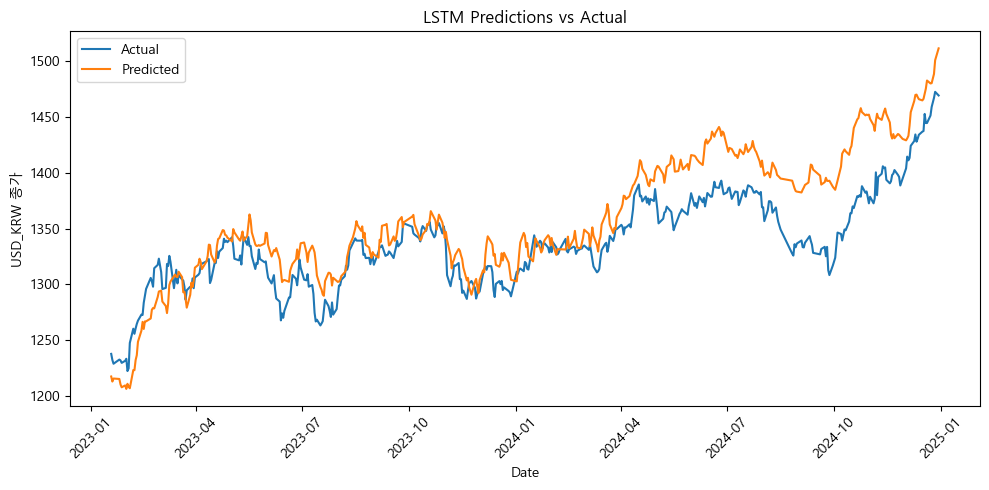

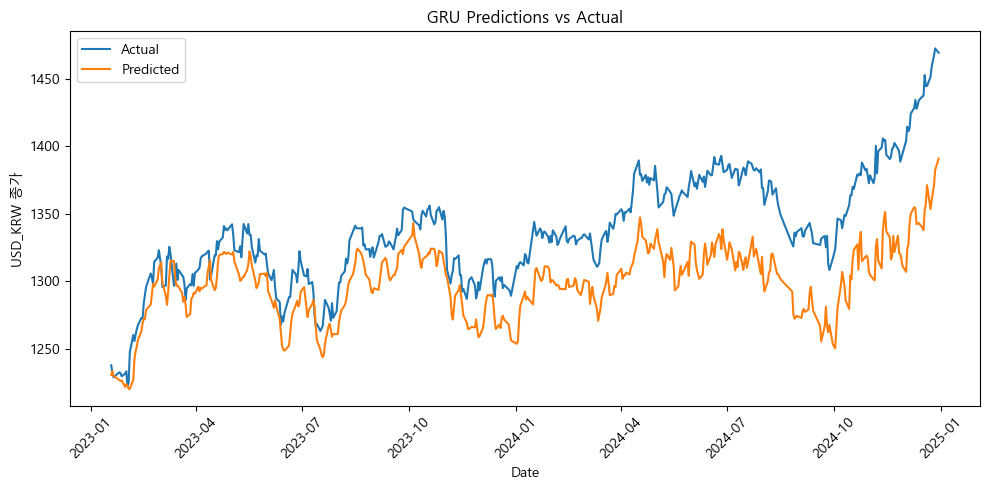

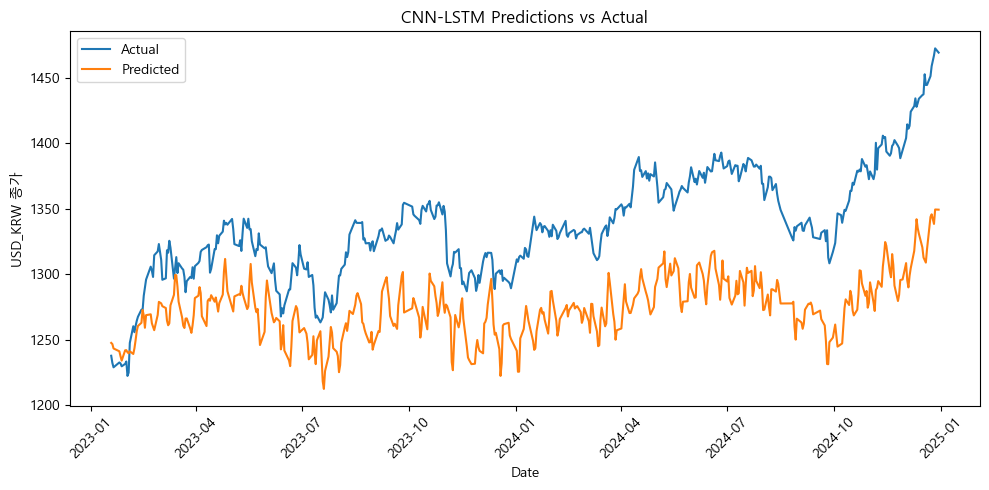

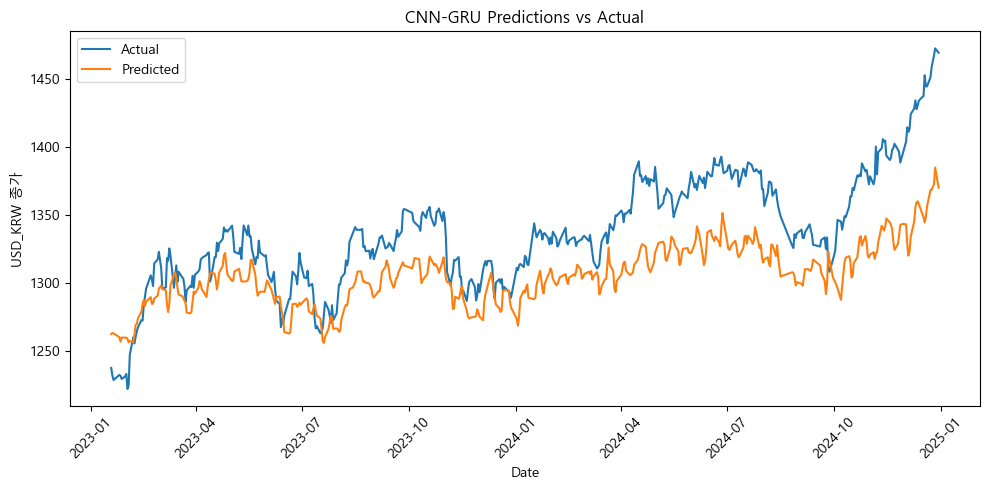

In [12]:
## 6. 시각화
# 테스트셋에 대해 각 모델별 예측값과 실제값을 비교
pred_lstm = lstm_model.predict(X_test)
pred_gru = gru_model.predict(X_test)
pred_cnn_lstm = cnn_lstm_model.predict(X_test_cnn)
pred_cnn_gru = cnn_gru_model.predict(X_test_cnn)

# 기존 예측값과 실제 y값 복원
target_min = scaler.data_min_[0]
target_range = scaler.data_range_[0]

y_true_actual = y_test * target_range + target_min
pred_lstm_actual = pred_lstm.flatten() * target_range + target_min
pred_gru_actual = pred_gru.flatten() * target_range + target_min
pred_cnn_lstm_actual = pred_cnn_lstm.flatten() * target_range + target_min
pred_cnn_gru_actual = pred_cnn_gru.flatten() * target_range + target_min

# 날짜 추출
dates_test = test_df['date'].reset_index(drop=True)
x_dates = dates_test[window_size:].values

# 시각화 
def plot_predictions_actual(x_dates, y_true, y_pred, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(x_dates, y_true, label='Actual')
    plt.plot(x_dates, y_pred, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('USD_KRW 종가')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 각 모델별 시각화
plot_predictions_actual(x_dates, y_true_actual, pred_lstm_actual, 'LSTM')
plot_predictions_actual(x_dates, y_true_actual, pred_gru_actual, 'GRU')
plot_predictions_actual(x_dates, y_true_actual, pred_cnn_lstm_actual, 'CNN-LSTM')
plot_predictions_actual(x_dates, y_true_actual, pred_cnn_gru_actual, 'CNN-GRU')